In [35]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
import os
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.window import Window
from offline_models.Graphics import Graphics
import pandas as pd
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover, CountVectorizer
from deep_translator import GoogleTranslator

spark = SparkSession.builder \
    .appName("PreProcess") \
    .config("spark.sql.pivotMaxValues", "100000") \
    .getOrCreate()
DISPLAY = False # True/False para ver os displays

In [36]:
links_path = '../input/links_small.csv' # usando small pra ir mais rapido
df_links = spark.read.csv(links_path, header=True)

ratings_path = '../input/ratings_small.csv'# usando small pra ir mais rapido
df_ratings = spark.read.csv(ratings_path, header=True)

movies_metadata_path = '../input/movies_metadata.csv'
df_movies = spark.read.csv(movies_metadata_path, header=True)

keywords_path = '../input/keywords.csv'
df_keywords = spark.read.csv(keywords_path, header=True)

credits_path = '../input/credits.csv'
df_credits = spark.read.csv(credits_path, header=True)

stopwords_path = '../input/stopwords.txt'
with open(stopwords_path, "r", encoding="utf-8") as file:
    stopwords = [linha.strip() for linha in file if linha.strip()]


### Movies_metadata

In [37]:
schema = T.ArrayType(T.StructType([
    T.StructField("id", T.StringType(), True),
    T.StructField("name", T.StringType(), True)
]))

w = Window().partitionBy('genres_explode.id')

df_genero = (
  df_movies
  .withColumn("genres_array", F.from_json("genres", schema))
  .withColumn("imdbId", F.substring(F.col("imdb_id"), 3, 1000))# tirando tt
  .filter(F.col('genres_array.name').isNotNull())
  .withColumn("genres_explode", F.explode("genres_array"))
  .withColumn('num_aparicao', F.count("*").over(w))
  .where(F.col("num_aparicao") > 2)
  .selectExpr('imdbId', 'genres_explode.name as genero')
  .groupBy("imdbId") 
  .pivot("genero") 
  .agg(F.lit(1)) 
  .na.fill(0)
  .withColumnRenamed('TV Movie', 'TVMovie')
  .withColumnRenamed('Science Fiction', 'ScienceFiction')
)

In [38]:
df_preprocess_movies = (
    df_movies
    .withColumn("imdbId", F.substring(F.col("imdb_id"), 3, 1000))# tirando tt
    .withColumn("adult", F.when(F.col("adult") == True, 1).otherwise(0))
    .withColumn("is_valid_title", F.when((F.col("title").cast(T.StringType()).isNotNull()) & (~F.col("title").rlike(r"[\[\]\{\}]")) & (~F.col("title").rlike(r"^\d+(\.\d+)?$")), True).otherwise(False))
    .filter(F.col("is_valid_title") == True)
    .withColumn("is_valid_overview", F.when((F.col("overview").cast(T.StringType()).isNotNull()) & (~F.col("overview").rlike(r"[\[\]\{\}]")) & (~F.col("overview").rlike(r"^\d+(\.\d+)?$")) & (F.length(F.col("overview")) >= 10), True).otherwise(False))
    .filter(F.col("is_valid_overview") == True)
    .withColumn("release_date", F.to_date(F.col("release_date"), "yyyy-MM-dd"))
    .withColumn('popularity', F.log1p(F.col('popularity').cast("float")))
    .withColumn('vote_average', F.col('vote_average').cast("float"))
    .filter((F.col('vote_average') >= 0) & (F.col('vote_average') <= 10))
    .withColumn('movie_overall_grade', F.round((F.col("vote_average")/10),2))
    .withColumn("movie_popularity", F.round(F.when(F.col("popularity")> 3, F.lit(1)).otherwise(F.col("popularity")/3),4))
    .select('imdbId', 'overview', 'adult', 'title', 'release_date',"movie_popularity","movie_overall_grade", "original_language")
    .dropna()
    .join(df_genero, on=["imdbId"], how="inner")
    .drop('Miramax Films')
)


In [39]:
def translate_text(text):
    if text is None:
        return None
    try:
        translated = GoogleTranslator(source='auto', target='en').translate(text)
        return translated
    except Exception as e:
        return text 
translate_udf = F.udf(translate_text, T.StringType())


df_preprocess = (
    df_preprocess_movies
    .withColumn("overview", F.when(
            F.col("original_language") != 'en', 
            translate_udf("overview")
        ).otherwise(F.col("overview")))
    .drop("original_language")
)


In [42]:

regex_pattern = r'[^\w\s]|\d'

# Aplica a função regexp_replace para limpar a coluna 'overview'
df_cleaned = (
    df_preprocess
    .withColumn("overview_cleaned", F.regexp_replace("overview", regex_pattern, ""))
    .withColumn("overview_cleaned", F.trim(F.regexp_replace("overview_cleaned", r'\s+', ' ')))
    .select("imdbId","overview_cleaned")
)

# Tokeniza o texto (divide o texto em palavras)
tokenizer = Tokenizer(inputCol="overview_cleaned", outputCol="words")
df_token = tokenizer.transform(df_cleaned)

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_overview = remover.transform(df_token)

# df_overview = (
#     df_overview
#     .withColumn("word", F.explode(F.col("filtered_words")))
#     .groupBy("imdbId", "word").count()
#     .groupBy("imdbId").pivot("word").sum("count").fillna(0)
# )



vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
model = vectorizer.fit(df_overview)
df_features = model.transform(df_overview)



In [43]:
df_features.show(truncate=False)

+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------

In [44]:
train_path = os.path.join('./words')
df_features.repartition(5).write.mode('overwrite').parquet(train_path)

24/11/05 10:18:53 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1446459 ms exceeds timeout 120000 ms
24/11/05 10:18:53 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/05 10:18:58 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

KeyboardInterrupt: 

24/11/05 10:19:08 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:295)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1928)

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, trim
from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer

# Inicializa a sessão Spark
spark = SparkSession.builder \
    .appName("TextCleaning") \
    .config("spark.sql.pivotMaxValues", "20000") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

# Exemplo de DataFrame
data = [("the game for 26 years -- into their",),
        ("Outro exemplo: com barras / e traços - e aspas \"",)]
df = spark.createDataFrame(data, ["overview"])

# Mostra o DataFrame original
df.show(truncate=False)

# Define a expressão regular para remover caracteres especiais e números
regex_pattern = r'[^\w\s]|\d'

# Aplica a função regexp_replace para limpar a coluna 'overview'
df_cleaned = (
    df.withColumn("overview_cleaned", regexp_replace("overview", regex_pattern, ""))
      .withColumn("overview_cleaned", trim(regexp_replace("overview_cleaned", r'\s+', ' ')))
      .select("overview", "overview_cleaned")
)

# Tokeniza o texto (divide o texto em palavras)
tokenizer = Tokenizer(inputCol="overview_cleaned", outputCol="words")
df_token = tokenizer.transform(df_cleaned)

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_no_stopwords = remover.transform(df_token)

# Vetoriza as palavras
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")
model = vectorizer.fit(df_no_stopwords)
df_features = model.transform(df_no_stopwords)

# Converte a matriz esparsa em um DataFrame onde cada palavra é uma coluna
vocab = model.vocabulary
df_final = df_features.select("overview", "features")

# Função para converter a matriz esparsa em colunas
def to_dense(df, vocab):
    from pyspark.sql.functions import udf
    from pyspark.sql.types import ArrayType, DoubleType
    import numpy as np

    def dense_vector_to_array(v):
        return v.toArray().tolist()

    dense_vector_to_array_udf = udf(dense_vector_to_array, ArrayType(DoubleType()))
    df_dense = df.withColumn("features_array", dense_vector_to_array_udf(col("features")))

    for i, word in enumerate(vocab):
        df_dense = df_dense.withColumn(word, col("features_array")[i])

    return df_dense.drop("features_array", "features")

df_final = to_dense(df_final, vocab)

# Mostra o DataFrame final com as palavras como colunas
df_final.show(truncate=False)


24/11/03 21:57:00 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


+------------------------------------------------+
|overview                                        |
+------------------------------------------------+
|the game for 26 years -- into their             |
|Outro exemplo: com barras / e traços - e aspas "|
+------------------------------------------------+



+------------------------------------------------+---+-----+-----+------+----+---+-----+-----+-------+
|overview                                        |e  |outro|traos|barras|game|com|years|aspas|exemplo|
+------------------------------------------------+---+-----+-----+------+----+---+-----+-----+-------+
|the game for 26 years -- into their             |0.0|0.0  |0.0  |0.0   |1.0 |0.0|1.0  |0.0  |0.0    |
|Outro exemplo: com barras / e traços - e aspas "|2.0|1.0  |1.0  |1.0   |0.0 |1.0|0.0  |1.0  |1.0    |
+------------------------------------------------+---+-----+-----+------+----+---+-----+-----+-------+



In [21]:
df_no_stopwords.select("overview","overview_cleaned","words","filtered_words").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------

In [23]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, trim, explode
from pyspark.ml.feature import StopWordsRemover, Tokenizer

# Inicializa a sessão Spark
spark = SparkSession.builder.appName("TextCleaning").getOrCreate()

# Exemplo de DataFrame
data = [("the game for 26 years -- into their",),
        ("Outro exemplo: com barras / e traços - e aspas \"",)]
df = spark.createDataFrame(data, ["overview"])

# Mostra o DataFrame original
df.show(truncate=False)

# Define a expressão regular para remover caracteres especiais e números
regex_pattern = r'[^\w\s]|\d'

# Aplica a função regexp_replace para limpar a coluna 'overview'
df_cleaned = df.withColumn("overview_cleaned", regexp_replace("overview", regex_pattern, ""))

# Remove múltiplos espaços e espaços no início e no final da string
df_cleaned = df_cleaned.withColumn("overview_cleaned", trim(regexp_replace("overview_cleaned", r'\s+', ' ')))

# Tokeniza o texto (divide o texto em palavras)
tokenizer = Tokenizer(inputCol="overview_cleaned", outputCol="words")
df_tokenized = tokenizer.transform(df_cleaned)

# Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
df_no_stopwords = remover.transform(df_tokenized)

# Explode a coluna de palavras em múltiplas linhas
df_exploded = df_no_stopwords.withColumn("word", explode(col("filtered_words")))

# Conta as ocorrências de cada palavra
df_word_count = df_exploded.groupBy("overview", "word").count()

# Pivot para transformar palavras em colunas
df_pivot = df_word_count.groupBy("overview").pivot("word").sum("count").fillna(0)

# Mostra o DataFrame final com as palavras como colunas
df_pivot.show(truncate=False)

+------------------------------------------------+
|overview                                        |
+------------------------------------------------+
|the game for 26 years -- into their             |
|Outro exemplo: com barras / e traços - e aspas "|
+------------------------------------------------+

+------------------------------------------------+-----+------+---+---+-------+----+-----+-----+-----+
|overview                                        |aspas|barras|com|e  |exemplo|game|outro|traos|years|
+------------------------------------------------+-----+------+---+---+-------+----+-----+-----+-----+
|Outro exemplo: com barras / e traços - e aspas "|1    |1     |1  |2  |1      |0   |1    |1    |0    |
|the game for 26 years -- into their             |0    |0     |0  |0  |0      |1   |0    |0    |1    |
+------------------------------------------------+-----+------+---+---+-------+----+-----+-----+-----+



In [5]:
train_path = os.path.join('./words','movies')
df_preprocess_movies.repartition(5).write.mode('overwrite').parquet(train_path)

In [6]:
df_preprocess_movies.show(truncate=False)

+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------------------------------------+------------+----------------+-------------------+-----------------+------+---------+---------+------+-----+-----------+-----+------+-------+-------+-------+------+

In [11]:

contagem_valores = df_preprocess_movies.groupBy("original_language").count().orderBy("count", ascending=False)

# Exibe o resultado
contagem_valores.show()


+-----------------+-----+
|original_language|count|
+-----------------+-----+
|               en|27870|
|               fr| 1968|
|               ja| 1161|
|               it| 1065|
|               de|  840|
|               es|  804|
|               ru|  667|
|               hi|  451|
|               ko|  402|
|               zh|  350|
|               sv|  338|
|               cn|  270|
|               pt|  264|
|               nl|  204|
|               da|  199|
|               fi|  191|
|               pl|  145|
|               cs|  111|
|               fa|   92|
|               tr|   92|
+-----------------+-----+
only showing top 20 rows



In [15]:
df_preprocess_movies.filter(df_preprocess_movies.original_language == "pt").orderBy("movie_overall_grade", ascending=False).show(truncate=False)

+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+--------------------------------------+------------+----------------+-------------------+-----------------+------+---------+---------+------+-----+-----------+-----+------+-------+-------+-------+------+-----+-------+-------+--------------+-------+--------+---+-------+
|imdbId |overview        

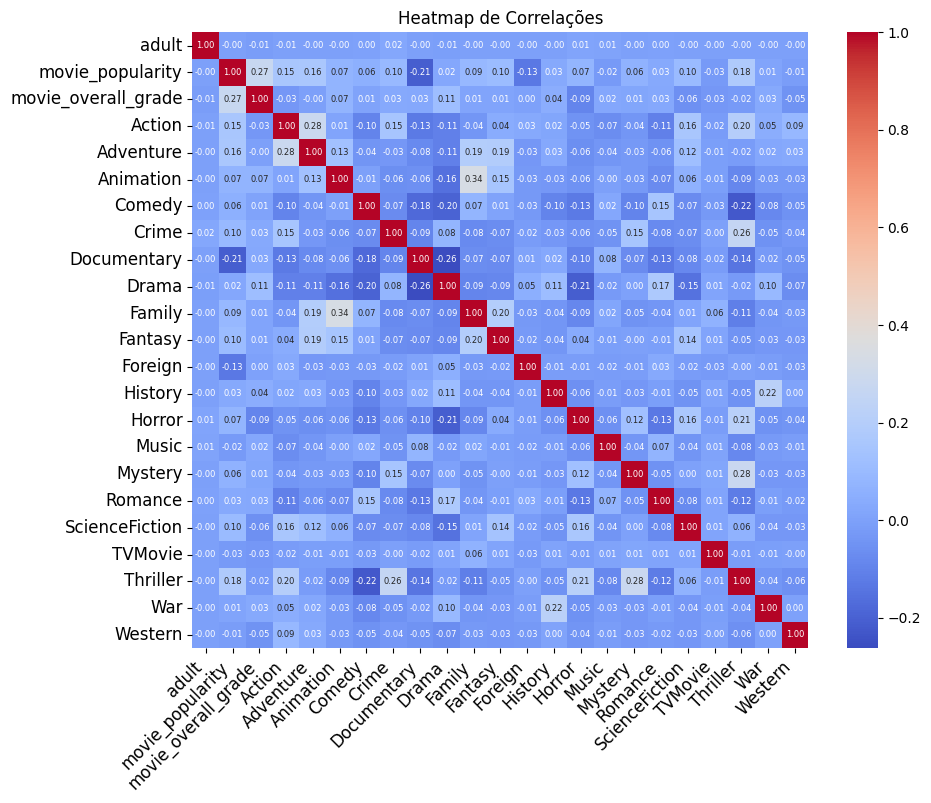

In [7]:
df_acao_pandas = df_preprocess_movies.toPandas()
df = df_acao_pandas.drop(columns=['imdbId', 'overview', 'title', 'release_date'])
plot = Graphics()
plot.correlation_matrix(df)

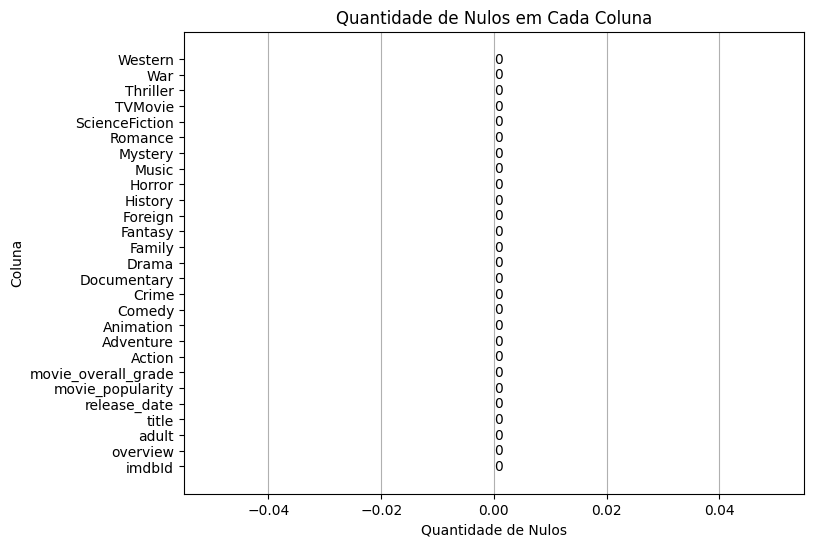

In [40]:
quantidade_nulos = [df_preprocess_movies.filter(F.col(coluna).isNull()).count() for coluna in df_preprocess_movies.columns]
nomes_colunas = df_preprocess_movies.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()


In [78]:
print(df_preprocess_movies.count())
print(df_movies.count())



38538
45572


### Credits

In [81]:
schema = T.ArrayType(T.StructType([
    T.StructField("cast_id", T.IntegerType(), True),
    T.StructField("character", T.StringType(), True),
    T.StructField("credit_id", T.StringType(), True),
    T.StructField("gender", T.IntegerType(), True),
    T.StructField("id", T.IntegerType(), True),
    T.StructField("name", T.StringType(), True),
    T.StructField("order", T.IntegerType(), True),
    T.StructField("profile_path", T.StringType(), True)
]))

df_exploded = (
    df_credits
    .withColumn("cast", F.from_json("cast", schema))
    .withColumn("cast", F.explode("cast"))
)

df_cast = (
    df_exploded
    .filter(F.col("id").rlike("^\d+$"))
    .select(
        F.col("id").alias("movie_id"),
        F.col("cast.cast_id"),
        F.col("cast.character"),
        F.col("cast.credit_id"),
        F.col("cast.gender"),
        F.col("cast.id").alias("actor_id"),
        F.col("cast.name").alias("actor_name"),
    )
)

In [84]:
df_cast.show(truncate=False)

+--------+-------+----------------------------+------------------------+------+--------+-------------------------+
|movie_id|cast_id|character                   |credit_id               |gender|actor_id|actor_name               |
+--------+-------+----------------------------+------------------------+------+--------+-------------------------+
|15602   |2      |Max Goldman                 |52fe466a9251416c75077a8d|2     |6837    |Walter Matthau           |
|15602   |3      |John Gustafson              |52fe466a9251416c75077a91|2     |3151    |Jack Lemmon              |
|15602   |4      |Ariel Gustafson             |52fe466a9251416c75077a95|1     |13567   |Ann-Margret              |
|15602   |5      |Maria Sophia Coletta Ragetti|52fe466a9251416c75077a99|1     |16757   |Sophia Loren             |
|15602   |6      |Melanie Gustafson           |52fe466a9251416c75077a9d|1     |589     |Daryl Hannah             |
|15602   |9      |Grandpa Gustafson           |53e5fcc2c3a3684430000d65|2     |1

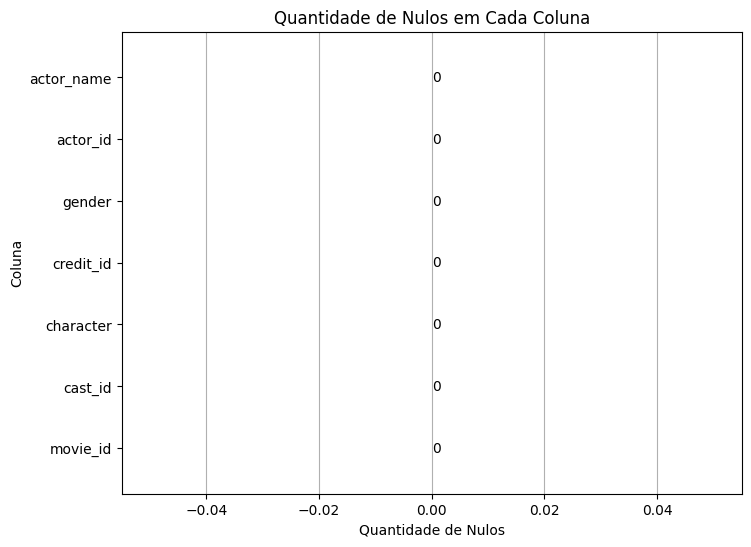

In [82]:
quantidade_nulos = [df_cast.filter(F.col(coluna).isNull()).count() for coluna in df_cast.columns]
nomes_colunas = df_cast.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

In [83]:
print(df_credits.count())
print(df_cast.count())

45476
59555


### Keywords

In [59]:
schema = T.ArrayType(T.StructType([
    T.StructField("id", T.IntegerType(), True),
    T.StructField("name", T.StringType(), True)
]))

df_exploded = (
    df_keywords
    .filter(F.col("id").rlike("^\d+$"))
    .withColumn("keywords", F.from_json("keywords", schema))
    .withColumn("keywords", F.explode("keywords"))
    .withColumn("keyword_name", F.trim(F.col("keywords.name")))
)

window_spec = Window.partitionBy("partition").orderBy(F.desc("count"))
df_keyword_counts = (
    df_exploded
    .groupBy("keyword_name")
    .count()
    .withColumn("partition", F.lit(1))  
    .withColumn("keyword_id", F.row_number().over(window_spec))
)

df_keyword_edit = (
    df_exploded
    .join(df_keyword_counts, on="keyword_name", how="inner")
    .select(
        F.col("id").alias("movie_id"),
        F.col("keyword_id"),
        F.col("keyword_name")
    )
)

In [60]:
df_keyword_edit.show(truncate=False)

+--------+----------+------------------------+
|movie_id|keyword_id|keyword_name            |
+--------+----------+------------------------+
|862     |75        |jealousy                |
|862     |1535      |toy                     |
|862     |341       |boy                     |
|862     |19        |friendship              |
|862     |92        |friends                 |
|862     |240       |rivalry                 |
|862     |6786      |boy next door           |
|862     |8870      |new toy                 |
|862     |1710      |toy comes to life       |
|15602   |1239      |fishing                 |
|15602   |152       |best friend             |
|15602   |18        |duringcreditsstinger    |
|15602   |9173      |old men                 |
|31357   |4         |based on novel          |
|31357   |837       |interracial relationship|
|31357   |388       |single mother           |
|31357   |143       |divorce                 |
|31357   |7543      |chick flick             |
|11862   |180

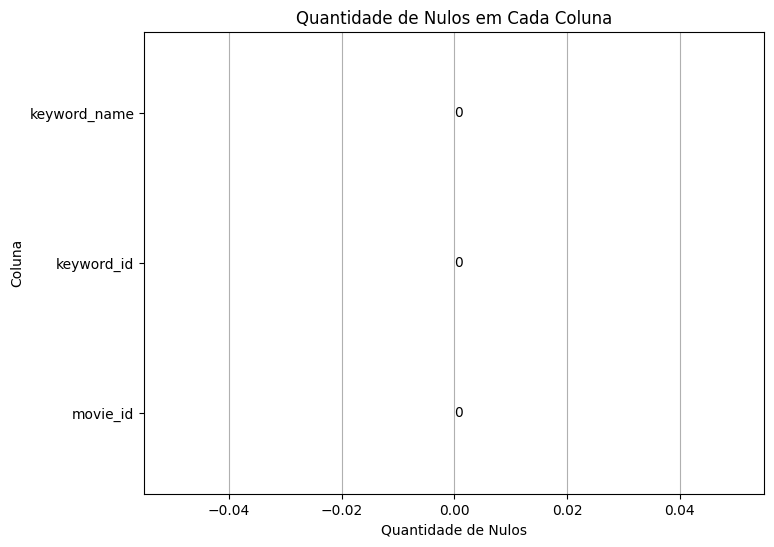

In [85]:
quantidade_nulos = [df_keyword_edit.filter(F.col(coluna).isNull()).count() for coluna in df_keyword_edit.columns]
nomes_colunas = df_keyword_edit.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

In [87]:
print(df_keywords.count())
print(df_keyword_edit.count())

46419
152592


### Ratings

In [62]:
df_ratings_2 = (
    df_ratings
    .withColumn('rating', F.round((F.col("rating")/5),2))
)

In [63]:
df_ratings_2.show(truncate=False)

+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|1     |110    |0.2   |1425941529|
|1     |147    |0.9   |1425942435|
|1     |858    |1.0   |1425941523|
|1     |1221   |1.0   |1425941546|
|1     |1246   |1.0   |1425941556|
|1     |1968   |0.8   |1425942148|
|1     |2762   |0.9   |1425941300|
|1     |2918   |1.0   |1425941593|
|1     |2959   |0.8   |1425941601|
|1     |4226   |0.8   |1425942228|
|1     |4878   |1.0   |1425941434|
|1     |5577   |1.0   |1425941397|
|1     |33794  |0.8   |1425942005|
|1     |54503  |0.7   |1425941313|
|1     |58559  |0.8   |1425942007|
|1     |59315  |1.0   |1425941502|
|1     |68358  |1.0   |1425941464|
|1     |69844  |1.0   |1425942139|
|1     |73017  |1.0   |1425942699|
|1     |81834  |1.0   |1425942133|
+------+-------+------+----------+
only showing top 20 rows



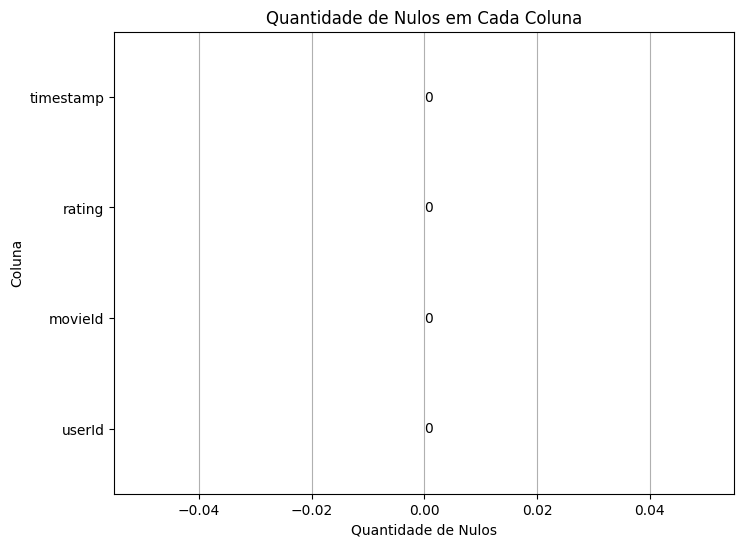

In [88]:
quantidade_nulos = [df_ratings_2.filter(F.col(coluna).isNull()).count() for coluna in df_ratings_2.columns]
nomes_colunas = df_ratings_2.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

In [89]:
print(df_ratings.count())
print(df_ratings_2.count())

26024289


26024289
